In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

c:\Users\apersonn\Miniconda3\envs\bot\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\apersonn\Miniconda3\envs\bot\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\apersonn\Miniconda3\envs\bot\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Chargement des différents jeux de données

In [2]:
interactions_train = pd.read_csv("data/interactions_train.csv")
interactions_test = pd.read_csv("data/interactions_test.csv") # On charge les données test car on ne fait pas de prédiction de score
raw_recipes = pd.read_csv("data/RAW_recipes.csv").sort_values(by="id")

In [3]:
# On retire les avis sans note
interactions_train.dropna(subset=['rating'], inplace=True)
interactions_test.dropna(subset=['rating'], inplace=True)

In [4]:
# Variable dummy juste pour la représentation graphique
interactions_test["test"] = True
interactions_train["test"] = False

In [5]:
interactions = pd.concat((interactions_train, interactions_test), ignore_index=True).sort_values(by="recipe_id")

# Exploration des données
On peut visualiser la répartition des données. Tout d'abord on remarque que la majorité des données provient du set d'entraînement.

Deuxièmement, près de $75\%$ des avis sont des $5$ étoiles, on va donc avoir une moyenne des avis très haute, ce qui risque de perturber notre score.

In [6]:
print(f"Pourcentage de données d'entraînement : {len(interactions_train)/len(interactions)*100:.3}%", )

Pourcentage de données d'entraînement : 98.2%


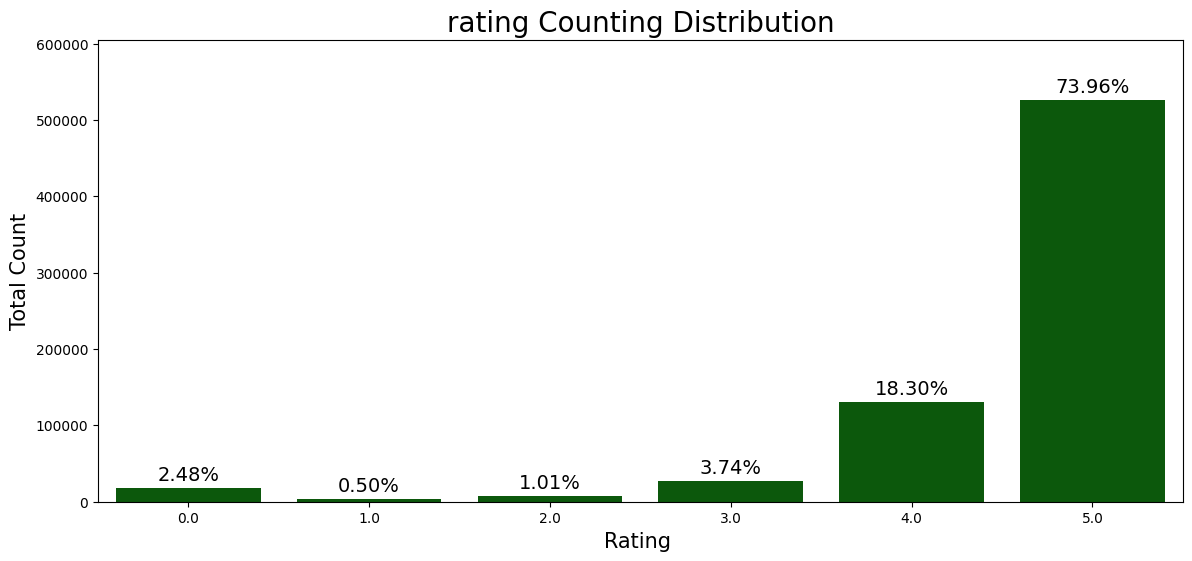

In [7]:
total = len(interactions)
plt.figure(figsize=(14,6))

g = sns.countplot(x='rating', color='darkgreen',
                  data=interactions)
g.set_title("rating Counting Distribution", fontsize=20)
g.set_xlabel("Rating ", fontsize=15)
g.set_ylabel("Total Count", fontsize=15)

sizes=[]

for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 10000,
            '{:1.2f}%'.format((height/total)*100),
            ha="center", fontsize=14) 
    
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

Visualisation du nombre de recettes publiés par an

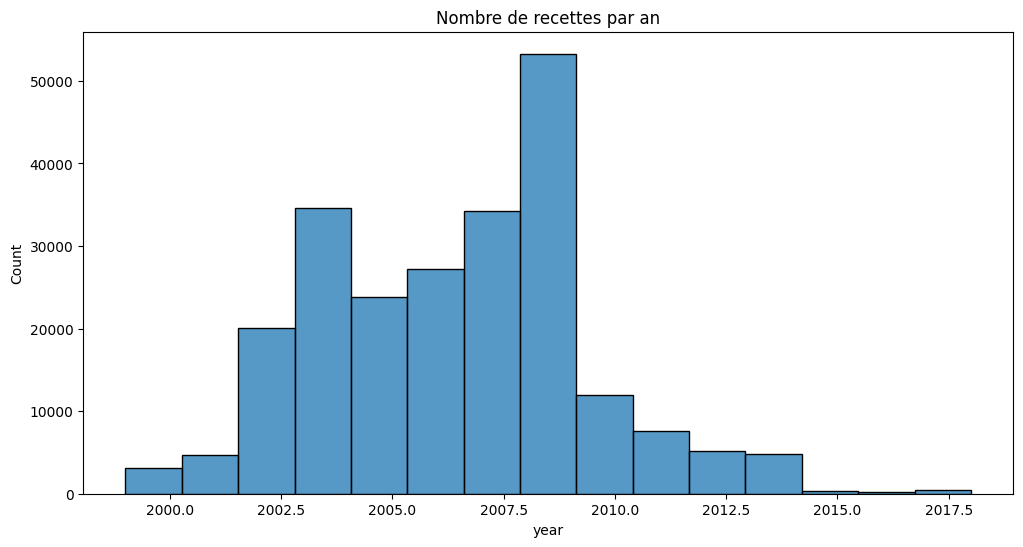

In [8]:
raw_recipes["year"] = raw_recipes["submitted"].str.split("-", expand = True)[0]
raw_recipes["year"] = raw_recipes["year"].fillna(-1).astype(int).replace(-1, np.nan)

plt.figure(figsize=(12,6))
sns.histplot(data=raw_recipes, x="year", bins = 15)
plt.title("Nombre de recettes par an")
plt.show()

# Recommandations par popularité
## Regroupement des votes par recettes et calcul du score IMDb
On va créer un *DataFrame* regroupant la moyenne et le nombre de vote par recettes avec une base de 0 s'il n'y pas d'avis.

In [9]:
recipes_tab = pd.DataFrame(index=raw_recipes["id"].unique(), columns=["vote_average", "vote_count"]).sort_index()
group = interactions[["recipe_id", "rating"]].groupby("recipe_id")
recipes_tab.vote_count = group.count()
recipes_tab.vote_average = group.mean()
recipes_tab.fillna(0, inplace=True)

On peut voir sur l'histogramme ci-dessous que la grande majorité des recettes ne possède que quelques avis avec 60k n'en possédant aucun et 80k seulement 1 (sur 231k recettes).

In [10]:
px.histogram(recipes_tab, "vote_count", log_y=True, log_x=False)

Pour le score IMDb on va choisir `m` tel que seulement $10\%$ des recettes possèdent plus de `m` avis.

In [11]:
m = recipes_tab.vote_count.quantile(0.9) 
c = (recipes_tab.vote_average*recipes_tab.vote_count).sum()/recipes_tab.vote_count.sum()

recipes_tab['imdb_score'] = (recipes_tab.vote_count/(recipes_tab.vote_count+m))*recipes_tab.vote_average+(m/(m+recipes_tab.vote_count))*c
recipes_tab.sort_values(by='imdb_score', ascending=False, inplace=True)
recipes_tab

,vote_average,vote_count,imdb_score
186029,5.000000,56.0,4.958171
55309,5.000000,48.0,4.951974
107059,5.000000,39.0,4.942369
166669,5.000000,35.0,4.936747
153877,5.000000,34.0,4.935165
...,...,...,...
179740,2.000000,9.0,3.027108
461088,0.500000,4.0,2.940661
174348,0.800000,5.0,2.855147
31510,0.250000,4.0,2.840661


## Définition dataset avec popularité intégrée

On va maintenant joindre ce dataframe de score avec le dataset contenant les informations globales sur les recettes afin de pouvoir choisir les recettes les plus populaires en fonction de certains critères (tags, durée, ingrédients, ...)

In [12]:
recipes_with_rating = raw_recipes.join(recipes_tab, on=["id"], how='left', validate='1:1')
recipes_with_rating.sort_values(by='imdb_score', ascending=False, inplace=True, ignore_index=True)

On définit une simple fonction pour pouvoir filtrer notre dataset en fonction d'une liste d'items sur une colonne en particulier.

In [13]:
def wrapper(filters_list, column_list):
    """
    Wrapper returning a filter function to pass to apply.
    filters_list: List of List of string we want in the columns
    column_lsit: List of columns to filter on
    Exemple: 
    >>> filter_fn = wrapper([["zucchini","goat cheese"], ['vegetarian']], ["ingredients", "tags"])
    >>> recipes_with_rating[recipes_with_rating.apply(filter_fn, axis=1)]
    >>> # will return recipes with zucchini and goat cheese in the ingredients column and vegetarian in the tags one
    """
    def filter_fn(row):
        return all([all([e in row[column] for e in filters]) for filters, column in zip(filters_list, column_list)])
    return filter_fn

In [14]:
def get_best_recipes(df, number=1, ingredients=[], tags=[]):
    if ingredients == []:
        if tags == []:
            return df.head(number)
        else:
            filter_fn = wrapper([tags], ["tags"])
    else:
        if tags == []:
            filter_fn = wrapper([ingredients], ["ingredients"])
        else:
            filter_fn = wrapper([ingredients, tags], ["ingredients", "tags"])
    return df[df.apply(filter_fn, axis=1)].head(number)


On peut maintenant facilement récupérer les 5 recettes végétariennes les plus populaires utilisant des courgettes et du chèvre.

In [24]:
best_recipes = get_best_recipes(recipes_with_rating, 5, ["zucchini","goat cheese"], ['vegetarian'])
best_recipes

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,year,vote_average,vote_count,imdb_score
7557,taste of summer salad,432217,15,37449,2010-07-06,"['weeknight', '15-minutes-or-less', 'time-to-m...","[40.9, 0.0, 14.0, 0.0, 4.0, 0.0, 2.0]",5,"['mix all the veggies and herbs in a bowl', 'p...",i made this using what fresh vegetables i had ...,"['tomatoes', 'zucchini', 'yellow squash', 'fre...",12,2010,5.0,5.0,4.764238
22515,ratatouille inspired by the animated film,392997,80,799208,2009-10-05,"['time-to-make', 'course', 'main-ingredient', ...","[143.1, 11.0, 37.0, 1.0, 7.0, 5.0, 6.0]",11,"['preheat oven to 375 degrees f', 'in a large ...",this recipe is from the christian science moni...,"['tomato puree', 'garlic cloves', 'onion', 'ex...",11,2009,5.0,3.0,4.711846
33624,zucchini and goat cheese stuffed sweet potatoes,44215,40,3288,2002-10-25,"['60-minutes-or-less', 'time-to-make', 'course...","[181.8, 9.0, 29.0, 7.0, 7.0, 5.0, 10.0]",11,['bake or microwave the sweet potatoes until d...,the cheese contrasts wonderfully with the subt...,"['sweet potatoes', 'margarine', 'zucchini', 's...",6,2002,5.0,2.0,4.675827
41808,creamy zucchini crostini,432165,22,573325,2010-07-06,"['30-minutes-or-less', 'time-to-make', 'course...","[225.0, 5.0, 13.0, 15.0, 18.0, 5.0, 13.0]",8,"['heat the olive oil in a non-stick skillet', ...","this is a wonderful appetiser, originally from...","['olive oil', 'zucchini', 'onion', 'garlic clo...",7,2010,4.8,5.0,4.673329
52143,moroccan missile,430702,65,37449,2010-06-22,"['weeknight', 'time-to-make', 'course', 'main-...","[330.9, 15.0, 44.0, 15.0, 18.0, 8.0, 17.0]",15,"['preheat oven to 400f', 'mix the tomato paste...","this wrap pays homage to couscous, and is wond...","['tomato paste', 'red wine vinegar', 'olive oi...",16,2010,5.0,1.0,4.629516


In [18]:
best_recipes["ingredients"].iloc[0], best_recipes["tags"].iloc[0]

("['tomatoes', 'zucchini', 'yellow squash', 'fresh corn', 'green onions', 'red bell pepper', 'fresh basil', 'fresh oregano', 'fresh thyme', 'fresh parsley', 'goat cheese', 'red wine vinaigrette']",
 "['weeknight', '15-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'salads', 'vegetables', 'american', 'southern-united-states', 'summer', 'vegan', 'vegetarian', 'dietary', 'seasonal', 'squash', 'tomatoes']")

Ou alors la meilleure recette française de cookie au chocolat.

In [20]:
best_recipes = get_best_recipes(recipes_with_rating, 1, ["chocolate"], ['cookie', 'french'])

In [23]:
best_recipes["ingredients"].iloc[0], best_recipes["tags"].iloc[0]

('[\'white flour\', \'unsweetened cocoa powder\', \'baking powder\', \'sea salt\', \'unsalted butter\', \'dark brown sugar\', \'white sugar\', \'eggs\', \'pure vanilla extract\', \'dark chocolate chips\', \'bittersweet chocolate\', "confectioners\' sugar"]',
 "['weeknight', '30-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'hand-formed-cookies', 'desserts', 'eggs-dairy', 'american', 'french', 'southern-united-states', 'european', 'holiday-event', 'kid-friendly', 'cookies-and-brownies', 'chocolate', 'grains', 'dietary', 'gifts', 'pasta-rice-and-grains']")

# Recommendation par les étapes et la description de la recette :

Le dataset étant trop grand, on récupère seulement une partie des données choisie au hasard. On prend un nombre d'avis $k=30000$.

In [ ]:
import random
random.seed(1)
subset = raw_recipes.iloc[random.sample(range(raw_recipes.shape[0]), k= 30000, ),:].reset_index(drop=True)

In [ ]:
del(raw_recipes)

In [ ]:
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
# Download stopwords list
stop_words = set(stopwords.words('english'))

# Interface lemma tokenizer from nltk with sklearn
class StemTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`']
    def __init__(self):
        self.stemmer = SnowballStemmer('english')
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

tokenizer=StemTokenizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Par les étapes
On commence par joindre toutes les étapes d'une recette en une chaîne de caractères.

In [ ]:
subset["all_steps"] = subset["steps"].apply(lambda x : ' '.join(eval(x)))
subset["all_steps"]

0        1) after your coffee has brewed , combine the ...
1        in a blender , combine the peaches , milk , or...
2        pre-heat oven to 350 degrees in a large , heav...
3        combine the flour , salt , hot water and short...
4        put chicken and cream cheese in a pot on stove...
                               ...                        
29995    halve the peppers , remove the ribs and seeds ...
29996    preheat oven to 400 degrees mix all of the ing...
29997    place chicken in a resealable plastic bag set ...
29998    preheat oven to 350 degrees f heat half the bu...
29999    preheat oven to 350 degrees fahrenheit with a ...
Name: all_steps, Length: 30000, dtype: object

In [ ]:
# Lemmatize the stop words
from sklearn.feature_extraction.text import TfidfVectorizer
token_stop = tokenizer(' '.join(stop_words))

tfidf = TfidfVectorizer(stop_words=token_stop, max_features=4000)
tfidf_matrix = tfidf.fit_transform(subset["all_steps"])

from sklearn.metrics.pairwise import cosine_distances
cosine_sim = cosine_distances(tfidf_matrix)

np.save("cosine_sim.npy", cosine_sim)
# cosine_sim = np.load("cosine_sim.npy")

In [ ]:
subset["name"].head(5)

0      cappuccino recipe without an expensive machine
1                              orange peach smoothies
2                             vegetarian kenyan curry
3          tgi friday s pot stickers w  dipping sauce
4                  stove top buffalo chicken wing dip
5                        banana date walnut breakfast
6     croissant   salmon  or ham  breakfast casserole
7                              bubbly cranberry punch
8                                   maple baked beets
9                                     steamed mussels
10                       king prawns in swahili sauce
11                 light salad dressing with shallots
12                  raspberry cheesecake cookie pizza
13                           grilled pork   pineapple
14               sweet ramadan dumplings   lokmit ady
15                            cleaning a cuttingboard
16                                    black margarita
17                            macadamia maple granola
18                          

In [ ]:
titles = subset['name']
indices = pd.Series(subset.index, index=subset['name'])

In [ ]:
def get_reco(title, sim_matrix):
  idx = indices[title]
  print(f'original: {title}')
  recos = sim_matrix[idx].argsort()[1:6]
  recos = titles.iloc[recos]
  print(recos)

Testons sur différentes recettes

In [ ]:
title = "vegetarian kenyan curry"
get_reco(title, cosine_sim)

print()
title = "croissant   salmon  or ham  breakfast casserole"
get_reco(title, cosine_sim)

print()
title = "apple walnut pancakes"
get_reco(title, cosine_sim)

original: vegetarian kenyan curry
28161                 chickpea and potato curry
28831                     cheesy bratwurst stew
13299    vindaloo  goan style hot and sour pork
22205    chickpea spinach curry over brown rice
12581                             lentil sambar
Name: name, dtype: object

original: croissant   salmon  or ham  breakfast casserole
16948                savory asparagus croissants
10737                            eggs a la russe
20620                    brandied peaches   yams
19074                        british brunch bake
27925    chocolate chunk croissant bread pudding
Name: name, dtype: object

original: apple walnut pancakes
4689           polish apple pancakes
27944             pancakes on the go
17679       family favorite pancakes
19545      sour cream apple pancakes
1326     melt in your mouth pancakes
Name: name, dtype: object


On retrouve bien des recettes de curry quand on donne une recette de curry, idem pour les petits-déjeuners et les pancakes.

In [ ]:
title = "vegetarian kenyan curry"
print("\nSteps to cook ", title, " : ")
i = 1
for step in eval(subset.loc[subset["name"] == title, "steps"].values[0]) :
  print("       step", i, ":", step)
  i+=1


title = "chickpea and potato curry"
i=1
print("\nSteps to cook ", title, " : ")
for step in eval(subset.loc[subset["name"] == title, "steps"].values[0]) :
  print("       step", i, ":", step)
  i+=1


Steps to cook  vegetarian kenyan curry  : 
       step 1 : pre-heat oven to 350 degrees
       step 2 : in a large , heavy skillet or pot , brown the onions in moderately hot oil along with the cumin seeds and mustard seeds
       step 3 : watch out for popping mustard seeds !
       step 4 : add the potato pieces , and stir to coat each piece with the spices
       step 5 : now add the remaining spices and continue to stir for several minutes
       step 6 : thin the tomato paste with about 2 / 3 cup of water
       step 7 : stir into the pot
       step 8 : add vegetables , one at a time , cooking for a minute or so between each addition , and put in the chickpeas last
       step 9 : you may opt to put the leafy greens in now or just before serving
       step 10 : if your pot is not oven proof , transfer mixture to one that is
       step 11 : cover with a lid or seal with foil and bake for about 45 minutes , checking after the first 20 minutes
       step 12 : the consistency sho

In [ ]:
del(cosine_sim)

## Par les descriptions

In [ ]:
raw_recipes = pd.read_csv("data/RAW_recipes.csv")
raw_recipes = raw_recipes.loc[~raw_recipes["description"].isna()]
print(raw_recipes.shape)

(226658, 12)


In [ ]:
print("Exemple d'une description : ", raw_recipes["description"].values[0])

Exemple d'une description :  autumn is my favorite time of year to cook! this recipe 
can be prepared either spicy or sweet, your choice!
two of my posted mexican-inspired seasoning mix recipes are offered as suggestions.


On prend à nouveau un sous-ensemble du dataset avec cette fois $k=40000$ car les descriptions sont plus courtes que les étapes. 

In [ ]:
import random
random.seed(1)
subset = raw_recipes.iloc[random.sample(range(raw_recipes.shape[0]), k= 40000),:].\
            reset_index(drop=True)
del(raw_recipes)

titles = subset['name']
indices = pd.Series(subset.index, index=subset['name'])

In [ ]:
subset["name"].head(20)

0                                   cardamom applesauce
1                               papeete tahitian prawns
2     whole wheat peanut butter banana bread with ch...
3                tomato lemon chicken breasts with sage
4                                 supreme sausage rolls
5                        banana raisin oatmeal pancakes
6                                 curried indian shrimp
7                            buss up shut  paratha roti
8     medallions of beef tenderloin with cabernet re...
9                          super creamy pumpkin pudding
10                        leek and pear english rarebit
11                                  low fat potato soup
12                           roast beef with vegetables
13                        ham  cheese and herb baguette
14                               the best brownies ever
15    coffee rubbed grilled porterhouse w  garlic or...
16                                          blood gravy
17               marinated cheese with peppers  

In [ ]:
# Lemmatize the stop words
from sklearn.feature_extraction.text import TfidfVectorizer
token_stop = tokenizer(' '.join(stop_words))

tfidf = TfidfVectorizer(stop_words=token_stop, max_features=4000)
tfidf_matrix = tfidf.fit_transform(subset["description"])

from sklearn.metrics.pairwise import cosine_distances
cosine_sim = cosine_distances(tfidf_matrix)

In [ ]:
title = "curried indian shrimp"
get_reco(title, cosine_sim)

print()
title = "ham  cheese and herb baguette"
get_reco(title, cosine_sim)

print()
title = "banana raisin oatmeal pancakes"
get_reco(title, cosine_sim)

original: curried indian shrimp
16346         plantains in coconut milk
32431               fragrant rice pilaf
1771               curry massalla gravy
26194    cumin  mint   coriander yogurt
19799      chaat pata aloo  potato dish
Name: name, dtype: object

original: ham  cheese and herb baguette
31710                              quick beer bread
5781            classic french bread for breadmaker
15319                    family time vegetable soup
35393    savory garbanzo bean  meat  loaf  chickpea
927                           easy soft breadsticks
Name: name, dtype: object

original: banana raisin oatmeal pancakes
22499        sophisticated southern buttermilk ice cream
33600                                farm stand brownies
30446    caramelized pears with dulce de leche ice cream
26770       five spice spareribs with hoisin honey glaze
32162                         jamaican jerk potato salad
Name: name, dtype: object


In [ ]:
title = "curried indian shrimp"
print("\nDescription of ", title, " : ")
print(subset.loc[subset["name"] == title, "description"].values[0])

title = "plantains in coconut milk"
print("\nDescription of the recommendation : ", title, " : ")
print(subset.loc[subset["name"] == title, "description"].values[0])


Description of  curried indian shrimp  : 
i love curries, this one turns out nicely.

Description of the recommendation :  plantains in coconut milk  : 
this is from kenya.  it could be for dessert or try with curries or fish.


In [ ]:
title = "ham  cheese and herb baguette"
print("\nDescription of ", title, " : ")
print(subset.loc[subset["name"] == title, "description"].values[0])

title = "quick beer bread"
print("\nDescription of the recommendation : ", title, " : ")
print(subset.loc[subset["name"] == title, "description"].values[0])


Description of  ham  cheese and herb baguette  : 
this french style loaf can be made from start to finish in a little over an hour.  it's a hearty loaf that is delicious sliced and lightly toasted and served with soups, stews, and salads

Description of the recommendation :  quick beer bread  : 
this recipe makes up quick as a wink and is very moist. it's great sliced and toasted or served pipping hot  with soups and salads. enjoy.


In [ ]:
title = "banana raisin oatmeal pancakes"
print("\nDescription of ", title, " : ")
print(subset.loc[subset["name"] == title, "description"].values[0])

title = "sophisticated southern buttermilk ice cream"
print("\nDescription of the recommendation : ", title, " : ")
print(subset.loc[subset["name"] == title, "description"].values[0])


Description of  banana raisin oatmeal pancakes  : 
these are great with maple syrup, honey, marmalade, or even cottage cheese! packed with wholesome fruity flavor. recipe is from bon appetit's february 2004 issue.

Description of the recommendation :  sophisticated southern buttermilk ice cream  : 
bon appetit, february 1994.


In [ ]:
del(cosine_sim)